# Investigating HTAN scRNA-seq with BigQuery

```
Title:   Investigating HTAN scRNA-seq with BigQuery
Author:  Dar'ya Y. Pozhidayeva (dpozhida@systemsbiology.org)
Created: 2022-6-30
Purpose: Explore single cell RNA seq data in HTAN.
URL:    NA 
Notes:  NA
```

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/master/HTAN/Python%20Notebooks/Investigating_Single_Cell_HTAN_Data.ipynb)

# 1. Introduction & Overview
[HTAN](https://humantumoratlas.org/) is a National Cancer Institute (NCI)-funded Cancer Moonshot<sup>SM</sup> initiative to construct 3-dimensional atlases of the dynamic cellular, morphological, and molecular features of human cancers as they evolve from precancerous lesions to advanced disease ([Cell April 2020](https://www.sciencedirect.com/science/article/pii/S0092867420303469) )

This notebook shows examples of how HTAN single cell RNA sequencing data can be accessed and analyzed using Python.

### 1.1 Notebook Goal

The goal of this notebook is to show users how public HTAN single cell data can be queried and assembled for further processing. The total time for this tutorial should be about **20 minutes**.

### 1.2 Inputs, Outputs, & Data

The input for this analysis is the HTAN single cell RNA sequencing data (Level 2, gene summarized). The data set is filtered according to a specific cell type and patient population. The data is pulled into this notebook a google cloud connection. 


Details regarding the data used:

Data was derived in April 2022 from an H5AD file (Synapse ID: syn25173299) submitted by the CHOP HTAN Center. This data set contains the subset of normal cells from patient samples. Data was generated using the 10X Genomics V3 chemistry and was processed using CellRanger, where reads were mapped to HG38. The 18 filtered gene-by-cell count matrices were combined into a bigger gene-by-cell count matrix and converted to a Seurat object, with the fraction of mitochondrial UMI and sample information added as the metadata. We computed cell cycle S phase and G/M2 phase scores using the CellCycleScoring function in Seurat, with cell cycle genes downloaded from https://satijalab.org/seurat/v3.2/cell_cycle_vignette.html. We additionally computed a heat shock gene signature score using the AddModuleScore function in Seurat using genes associated with heat shock proteins from HGNC (https://www.genenames.org/data/genegroup/#!/group/582). Next, we normalized the data using the NormalizeData function in Seurat. We selected the top 3,000 variably expressed genes (VEGs) using the FindVariableFeatures function in Seurat with the default setting. The VEGs were further scaled by the ScaleData function in Seurat. We also regressed out confounding factors including the fraction of mitochondrial UMIs, the total number of UMIs per cell, S phase score, G2/M phase score and heat shock score. We then performed principal component analysis (PCA) using the RunPCA function in Seurat with 50 principle components (PCs). The data were clustered using the FindNeighous and FindClusters functions, with the resolution=0.4. To reduce batch effect, we re-selected VEGs across the clusters. To do so, we summarized the count matrix into a gene-by-cluster count matrix and normalized it using the cpm function in the edgeR package with the parameter prior.count = 1. The top 3,000 VEGs across the normalized gene-by-cluster count matrix were used. Data were scaled, regressed out for confounding factors followed by PCA and clustering analyses. VEGs that were expressed in fewer than 1% of cells were removed from the analysis. This process of re-selecting VEGs was repeated once and the resulting top 50 PCs were used in Uniform Manifold Approximation and Projection (UMAP) using the RunUMAP function in Seurat for visualization with the default setting. 


# 2. Environment & Module Setup
The libraries used in this analysis fall into two categories: those needed for google cloud connection and those needed for the analysis itself.

In [ ]:
#If running in google colab, you may have to run the following.
!pip install scanpy
!pip install matplotlib==3.1.3

In [ ]:
# Data Analytics
import numpy as np
from scipy import stats
from scipy import sparse
import seaborn as sns

The following snipet controls plotting parameters.

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]

# 3. Google Authentication

Running the BigQuery cells in this notebook requires a Google Cloud Project, instructions for creating a project can be found in the [Google Documentation](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console). The instance needs to be authorized to bill the project for queries. For more information on getting started in the cloud see [Quick Start Guide to ISB-CGC](https://nbviewer.org/github/isb-cgc/Community-Notebooks/blob/master/Notebooks/Quick_Start_Guide_to_ISB_CGC.ipynb) and alternative authentication methods can be found in the [Google Documentation](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console).

In [ ]:
# GCP Libraries
from google.cloud import bigquery
from google.colab import auth
# if you're using Google Colab, authenticate to gcloud with the following
auth.authenticate_user()
# alternatively, use the gcloud SDK
#!gcloud auth application-default login

In [ ]:
# Alternatively, if you're running the notebook locally,
# on the command line use "gcloud auth application-default login"
# to generate a key, take note of where your credentials are saved
# and set the GOOGLE_APPLICATION_CREDENTIALS environment variable using
# the jupyter magic command "%env GOOGLE_APPLICATION_CREDENTIALS=<path to key>"
# then import "from google.cloud import bigquery"
# and you can continue to creating the BigQuery client below.

In [ ]:
## Setup ##
# set the google project that will be referenced for this notebook's computations
google_project = 'your-project'

# Create a client to access the data within BigQuery
client = bigquery.Client(google_project)

# 4. Querying data from BigQuery

By accessing the HTAN-joined tables, we can see cell, gene, and count data combined into one table.

## 4.1 Samples and Cells Per Age of Participant

First we can look at the number of samples by some demographics of interest. The data comes from the CHOP scRNAseq table from HTAN in isb-cgc-bq. 

Here we start with age groups:

In [ ]:

df1 = client.query("""
  SELECT
    Age,
    count(distinct(gender)) Number_Genders,
    count(distinct(Sample)) Number_Samples,
    count(distinct(Cell_Type)) Number_Cell_Types,
    count(distinct(Cell_Name)) Number_Cells,
    count(distinct(Therapy)) Number_Therapies
  FROM
    `isb-cgc-bq.HTAN.scRNAseq_CHOP_seurat_integrated_18MLLr_normal_final_rename_current`
  GROUP BY 1
  ORDER BY Number_Cells DESC # ASC # or DESC
    """).result().to_dataframe()

df1

,Age,Number_Genders,Number_Samples,Number_Cell_Types,Number_Cells,Number_Therapies
0,10M,1,3,15,11161,1
1,1M,1,2,13,6361,1
2,4M,2,3,15,5042,1
3,8M,1,1,14,2705,1
4,11M,1,1,15,2527,1
5,2M,1,2,15,2318,2
6,3M,2,2,15,1929,1
7,9M,1,1,9,1172,1
8,7M,1,1,15,1127,1
9,5D,1,1,9,1002,1


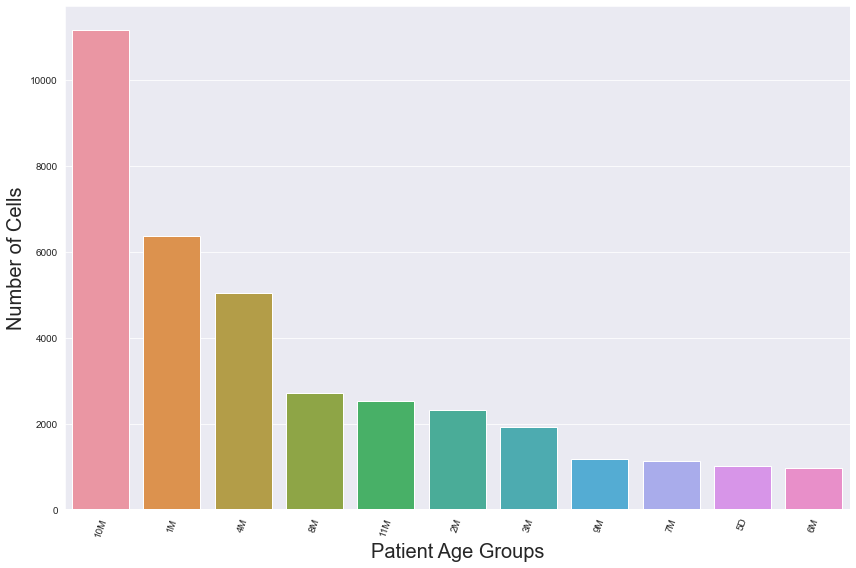

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]

p = sns.barplot(x=df1.Age, y=df1.Number_Cells)
p.set_xlabel("Patient Age Groups", fontsize = 20)
p.set_ylabel("Number of Cells", fontsize = 20)
plt.xticks(rotation=70)
plt.tight_layout()

Right away, we see that there are some differences in the age groups data was collected across. For example, 10M has the largest number of cells in terms of samples as well as indvidual cells.

Additionally, from the aggregate table above, not all ages have the same number of genders, cell types, or treatments. These aggregate tables help provide some context for our analysis based on our groups of interest. Limitations in cell types and demographics will impact the sort of analysis that can be performed and how generalizable the results are.

For the sake of this analysis, let's assume that we are interested in comparing the same cell types between two genders from the same age group. 
Looking at the table and plot, althought 10M is the largest demographic, that group only contains data for a single gender (males), so we will choose the age demographic that represents both: 4M.

In [ ]:

df2 = client.query("""
  SELECT
    Cell_Type,
    count(distinct(Gender)) Number_Genders,
    count(distinct(Cell_Name)) Number_Cells,
  FROM
    `isb-cgc-bq.HTAN.scRNAseq_CHOP_seurat_integrated_18MLLr_normal_final_rename_current`
  WHERE
    Age = '4M'
  GROUP BY 1
    """).result().to_dataframe()

df2

,Cell_Type,Number_Genders,Number_Cells
0,pDC,2,72
1,CD14_Monocyte,2,593
2,CD4_Early_Activation,2,247
3,CD4_Naive,2,1535
4,CD8_Naive,2,349
5,CD8_EffectorMemory,2,300
6,CD8_Cytotoxic,2,31
7,Unknown,2,10
8,NKT,2,192
9,CD56_NK,2,151


Now we see above that within this age, there are two genders available for each cell type. Next we decide that we can select the cell type that contains a roughly equal breakdown for genders in terms of the number of cells. Below, we see that CD14_Monocytes have a comprable number of cells and genes.

In [ ]:
df3 = client.query("""
  SELECT
  Gender,
  Cell_Type,
  count(distinct(Gene_Name)) Number_Genes,
  count(distinct(Cell_Name)) Number_Cells,
  FROM
    `isb-cgc-bq.HTAN.scRNAseq_CHOP_seurat_integrated_18MLLr_normal_final_rename_current`
  WHERE Age = '4M'
  GROUP BY 1,2
  ORDER BY Number_Genes DESC # ASC # or DESC
    """).result().to_dataframe()

df3

,Gender,Cell_Type,Number_Genes,Number_Cells
0,Male,CD4_Naive,13849,941
1,Female,CD16_Monocyte,13431,551
2,Female,CD14_Monocyte,13104,393
3,Male,CD14_Monocyte,12922,200
4,Female,CD4_Naive,12816,594
5,Male,Mature_B,12527,429
6,Male,CD16_Monocyte,12305,165
7,Male,CD8_EffectorMemory,12057,160
8,Male,CD8_Naive,12042,158
9,Male,CD4_Early_Activation,11725,184


[Text(0.5, 1.0, 'Gender and Cell Type')]

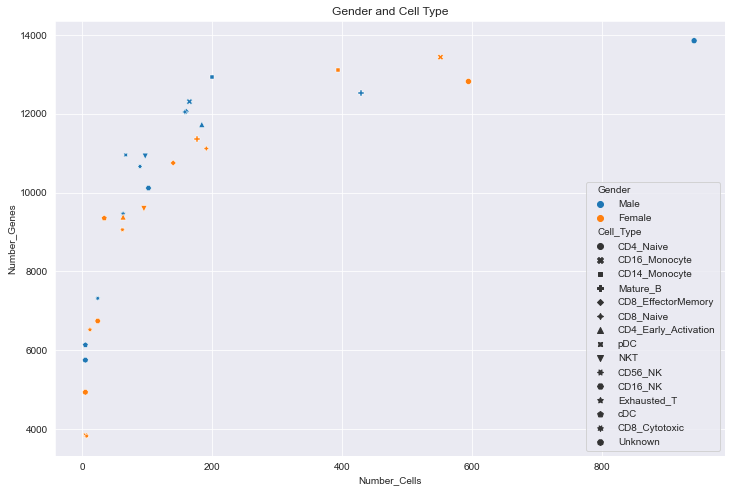

In [ ]:
sns.scatterplot(data=df3, x='Number_Cells', y='Number_Genes', hue='Gender', style='Cell_Type').set(title='Gender and Cell Type')


Next, once we select a cell type to focus on, we can also explore the Seurat Clusters generated for this data set. Maybe we are interested in comparing between males and females for the same cluster.

The following lines illustrate how to filter and check these clusters:

In [ ]:
df4 = client.query("""
  SELECT
  Gender,
  Seurat_Clusters,
  Cell_Type,
  count(distinct(Gene_Name)) Number_Genes,
  count(distinct(Cell_Name)) Number_Cells,
  FROM
    `isb-cgc-bq.HTAN.scRNAseq_CHOP_seurat_integrated_18MLLr_normal_final_rename_current`
  WHERE Age = '4M' AND Cell_Type = 'CD14_Monocyte'
  GROUP BY 1,2,3
  ORDER BY Cell_Type, Number_Genes DESC # ASC # or DESC
    """).result().to_dataframe()

df4

,Gender,Seurat_Clusters,Cell_Type,Number_Genes,Number_Cells
0,Male,10,CD14_Monocyte,12789,186
1,Female,7,CD14_Monocyte,12241,208
2,Female,10,CD14_Monocyte,11481,178
3,Male,7,CD14_Monocyte,8398,13
4,Female,21,CD14_Monocyte,4429,3
5,Female,8,CD14_Monocyte,3806,3
6,Male,21,CD14_Monocyte,2221,1
7,Female,3,CD14_Monocyte,1419,1


In this analysis, it might be interesting to compare cluster 10 between males and females. How do they differ in terms of gene expression?

## 4.2 Compare monocyte gene expression among clusters

Let's compare cluster 10 in the CD14_Monocytes for males vs. females using their gene expression.

In [ ]:
df5 = client.query("""
  SELECT
    Gender,
    Seurat_Clusters,
    count(distinct(Cell_Name)) as num_cells_clust10,
    Gene_Name, 
    AVG(X_value) as avg_counts_clust10
  FROM
    `isb-cgc-bq.HTAN.scRNAseq_CHOP_seurat_integrated_18MLLr_normal_final_rename_current`
  WHERE Age = '4M' AND Cell_Type = 'CD14_Monocyte' AND Seurat_Clusters = 10
  GROUP BY 1,2,4
  ORDER BY avg_counts_clust10 DESC
  LIMIT 10
    """).result().to_dataframe()

df5

,Gender,Seurat_Clusters,num_cells_clust10,Gene_Name,avg_counts_clust10
0,Male,10,186,MALAT1,6.111205
1,Male,10,186,MT-CO1,5.512180
2,Female,10,178,MALAT1,5.476113
3,Female,10,178,FTL,5.455267
4,Female,10,178,S100A9,5.374094
5,Male,10,186,MT-CO3,5.272379
6,Male,10,186,LYZ,5.115293
7,Male,10,186,FTL,5.074460
8,Female,10,178,FTH1,4.955120
9,Female,10,178,LYZ,4.925622


In the table above, we're interested in comparing the average expression values for genes between the genders shown.

To do this, we're going to make two aggregate tables for each gender and join them on the overlapping genes of interest.

In [ ]:
df6 = client.query("""

SELECT
  A.Gene_Name,
  A.avg_counts_clust10,
  B.avg_counts_clust10,
  A.avg_counts_clust10 - B.avg_counts_clust10 as mean_diff
FROM (
  SELECT
    Gene_Name,
    AVG(X_value) AS avg_counts_clust10
  FROM
    `isb-cgc-bq.HTAN.scRNAseq_CHOP_seurat_integrated_18MLLr_normal_final_rename_current`
  WHERE Age = '4M' AND Cell_Type = 'CD14_Monocyte' AND Seurat_Clusters = 10 AND Gender = 'Female'
  GROUP BY
    1) AS A
INNER JOIN (
  SELECT
    Gene_Name,
    AVG(X_value) AS avg_counts_clust10
  FROM
    `isb-cgc-bq.HTAN.scRNAseq_CHOP_seurat_integrated_18MLLr_normal_final_rename_current`
  WHERE Age = '4M' AND Cell_Type = 'CD14_Monocyte' AND Seurat_Clusters = 10 AND Gender = 'Male'
  GROUP BY
    1) AS B
ON
  A.Gene_Name = B.Gene_Name
GROUP BY 1,2,3
ORDER BY mean_diff DESC
LIMIT 200

    """).result().to_dataframe()

df6

,Gene_Name,avg_counts_clust10,avg_counts_clust10_1,mean_diff
0,DDIT4L,2.001699,0.508226,1.493473
1,TIAF1,1.827204,0.548018,1.279186
2,AC087500.1,1.915508,0.713525,1.201983
3,SYT15,1.856686,0.715204,1.141482
4,QPRT,1.827204,0.693095,1.134109
...,...,...,...,...
195,ZBTB11-AS1,1.408836,0.811069,0.597767
196,MERTK,1.659826,1.062495,0.597331
197,CDKN2B,1.408836,0.813152,0.595684
198,CAB39L,1.378804,0.783399,0.595406


In this way, we can calculate the mean difference of expression between the genes between the genders for the age, cell types and cluster we selected earlier.

We also plot the data like so:

<AxesSubplot:ylabel='mean_diff'>

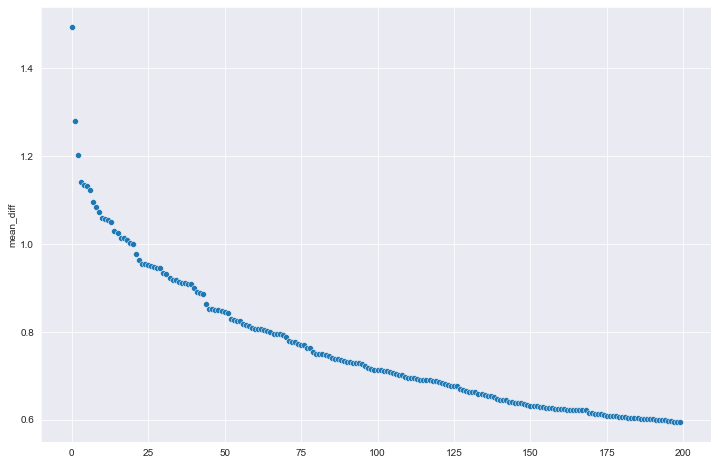

In [ ]:
sns.scatterplot(data=df6, x=range(0,200), y='mean_diff')


This allows us to see that there are mean differences of expression for the genes between males and females.

In this case the gene with the highest mean difference in this analysis is 
DNA-damage-inducible transcript 4 (DDIT4). This gene has been shown by [Wang et al.,](https://www.sciencedirect.com/science/article/pii/S0006497120408389) to be highly expressed and plays an important role in monocyte cells (*Shown in table 2: Top 50 genes most highly expressed by the intermediate monocyte subset sorted according to decreasing absolute fold change values.*).

In this notebook, we explored the data and compared the gene expression of a specific cell type between gendered samples that can be found within the HTAN CHOP data. This is meant as an example rather than a concrete analysis, so try these steps out yourself!


# 5. Relevant Citations and Links

[HTAN Portal](https://humantumoratlas.org/)

[Overview paper, Cell, April 2020](https://www.sciencedirect.com/science/article/pii/S0092867420303469)